In [2]:
# standard packages for data analysis and NLP

import numpy as np
import pandas as pd
from copy import deepcopy

#visualization packages
import seaborn as sns
import matplotlib.pyplot as plt

# NLP modules we will use for text normalization
import re #regex 
import nltk # the natural language toolkit
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk import pos_tag

# feature construction
from sklearn.feature_extraction.text import TfidfVectorizer #use this to create BoW matrix

# import pyLDAvis.sklearn # a specialized package for topic model visualization

#modeling and dimensionality reduction for visuaization
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

# import data
and basic checks

In [3]:
df = pd.read_csv('raw_data/Steam_Game_Review_Dataset/train_gr/train.csv')
df.head()

,review_id,title,year,user_review,user_suggestion
0,1,Spooky's Jump Scare Mansion,2016.0,I'm scared and hearing creepy voices. So I'll...,1
1,2,Spooky's Jump Scare Mansion,2016.0,"Best game, more better than Sam Pepper's YouTu...",1
2,3,Spooky's Jump Scare Mansion,2016.0,"A littly iffy on the controls, but once you kn...",1
3,4,Spooky's Jump Scare Mansion,2015.0,"Great game, fun and colorful and all that.A si...",1
4,5,Spooky's Jump Scare Mansion,2015.0,Not many games have the cute tag right next to...,1


In [4]:
df.shape

(17494, 5)

# preprocessing

* Capitalization
* Special pattern
* Numbers

In [6]:
# additional argument sets cut off minimum length for tokenized text at which function converts to null string.
def process_text(text, min_length):
    
    # get common stop words that we'll remove during tokenization/text normalization
    stop_words = stopwords.words('english')

    #initialize lemmatizer
    wnl = WordNetLemmatizer()

    # helper function to change nltk's part of speech tagging to a wordnet format.
    def pos_tagger(nltk_tag):
        if nltk_tag.startswith('J'):
            return wordnet.ADJ
        elif nltk_tag.startswith('V'):
            return wordnet.VERB
        elif nltk_tag.startswith('N'):
            return wordnet.NOUN
        elif nltk_tag.startswith('R'):
            return wordnet.ADV
        else:         
            return None
   

    # lower case everything
    text_lower = text.lower()
    
    # remove stop words and punctuations 
    text_norm = [x for x in word_tokenize(text_lower) if ((x.isalpha()) & (x not in stop_words)) ]

    #  POS detection on the result will be important in telling Wordnet's lemmatizer how to lemmatize
    
    # creates list of tuples with tokens and POS tags in wordnet format
    wordnet_tagged = list(map(lambda x: (x[0], pos_tagger(x[1])), pos_tag(text_norm))) 

    # now we are going to have a cutoff here. any tokenized cocument with length < min length will be removed from corpus
    if len(wordnet_tagged) <= min_length:
        return ''
    else:
         # rejoins lemmatized sentence 
         text_norm = " ".join([wnl.lemmatize(x[0], x[1]) for x in wordnet_tagged if x[1] is not None])
         return text_norm

In [7]:
df['user_review'] = df['user_review'].apply(process_text, min_length = 10)

In [8]:
df_new = df[df['user_review'] != '']

In [9]:
corpus = df_new['user_review']
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(corpus)
X_train

<17392x41675 sparse matrix of type '<class 'numpy.float64'>'
	with 844709 stored elements in Compressed Sparse Row format>

In [10]:
len(vectorizer.get_feature_names())

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


41675

# Topic Modeling

-6

In [11]:
topic_model = NMF(n_components = 7)
topic_model.fit(X_train)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=7)

In [12]:
# to get H
H = topic_model.transform(X_train) # transform document into topic vector representation

# to get W 
W = topic_model.components_ # word component weights for each topic

print("Shape of W is " + str(W.shape))
print("Shape of H is " + str(H.shape))
print("Shape of X_train is " + str(X_train.shape))

Shape of W is (7, 41675)
Shape of H is (17392, 7)
Shape of X_train is (17392, 41675)


- W

In [13]:
for index,topic in enumerate(W):
    print(f'THE TOP 10 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-25:]])
    print('\n')

THE TOP 10 WORDS FOR TOPIC #0


c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['think', 'look', 'graphic', 'well', 'people', 'say', 'enjoy', 'lot', 'try', 'steam', 'ever', 'hour', 'much', 'time', 'best', 'good', 'friend', 'recommend', 'love', 'really', 'free', 'great', 'fun', 'play', 'game']


THE TOP 10 WORDS FOR TOPIC #1
['power', 'rank', 'elder', 'mode', 'gold', 'opponent', 'ai', 'generous', 'reward', 'get', 'win', 'mechanic', 'game', 'player', 'draft', 'eternal', 'play', 'mana', 'pack', 'mtg', 'draw', 'magic', 'hearthstone', 'deck', 'card']


THE TOP 10 WORDS FOR TOPIC #2
['great', 'make', 'bug', 'potential', 'issue', 'alpha', 'bad', 'graphic', 'reviewit', 'devs', 'update', 'fortnite', 'reviewthe', 'fun', 'fix', 'well', 'battle', 'royale', 'pubg', 'good', 'reviewi', 'reviewthis', 'game', 'access', 'early']


THE TOP 10 WORDS FOR TOPIC #3
['weapon', 'try', 'item', 'still', 'back', 'start', 'give', 'system', 'class', 'server', 'take', 'people', 'update', 'use', 'game', 'character', 'thing', 'level', 'go', 'even', 'time', 'make', 'new', 'player', 'get']


THE T

In [24]:
%%capture topic_word_plot
def plot_top_words(W, feature_names, n_top_words, title, n_topics):
    fig, axes = plt.subplots(1, n_topics, figsize=(15, 8), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(W):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model",7)

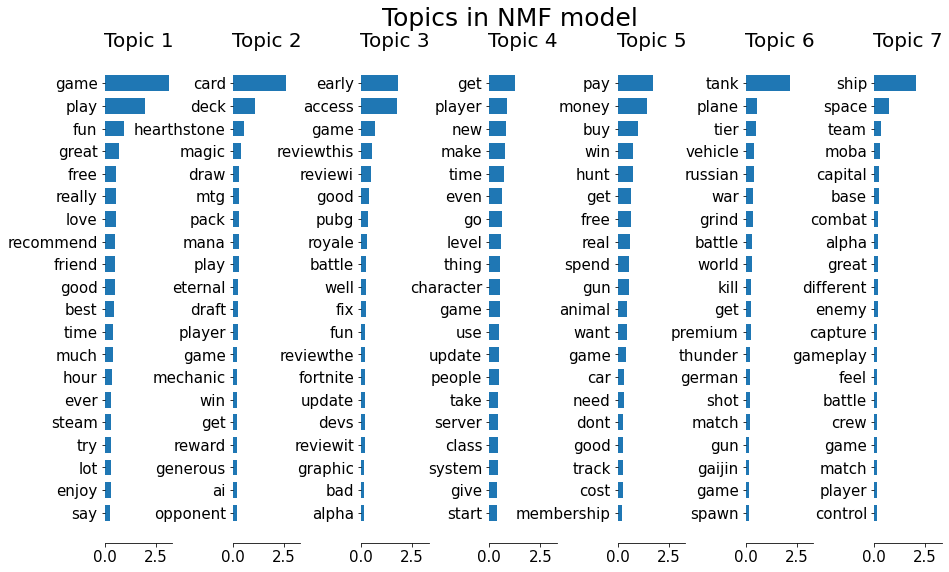

In [15]:
topic_word_plot()

In [16]:
topic_name_dict = {0: 'really fun game for friend', 1: 'magic deck card game', 2: 'PUBG Early Access',
                   3: 'fortnite type', 4: 'hunting game', 5:'russian german war', 6:'spaceship'}

- PyLDAvis

In [ ]:
# vis = pyLDAvis.sklearn.prepare(topic_model, X_train, vectorizer)
# pyLDAvis.display(vis)
# pyLDAvis.save_html(vis, 'nmf_topics.html')

# TSNE

In [17]:
tsne = TSNE(random_state=42, learning_rate=100)
tsne_trans = tsne.fit_transform(H)
tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


In [18]:
tsne_trans['class'] = np.argmax(H, axis = 1)
tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)


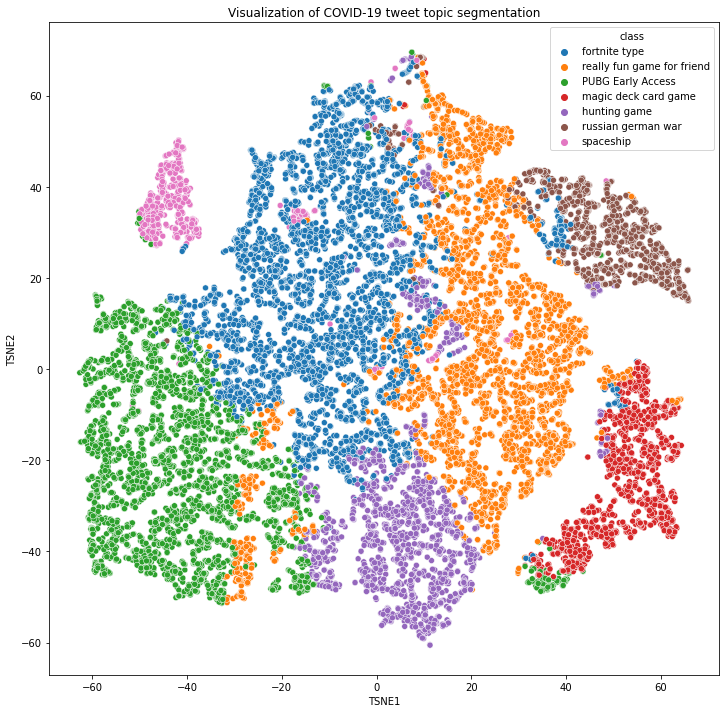

In [19]:
plt.figure(figsize=(12,12))
sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
plt.title('Visualization of COVID-19 tweet topic segmentation')
plt.show()

-6

In [31]:
topic_model9 = NMF(n_components = 15)
topic_model9.fit(X_train)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


NMF(n_components=15)

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


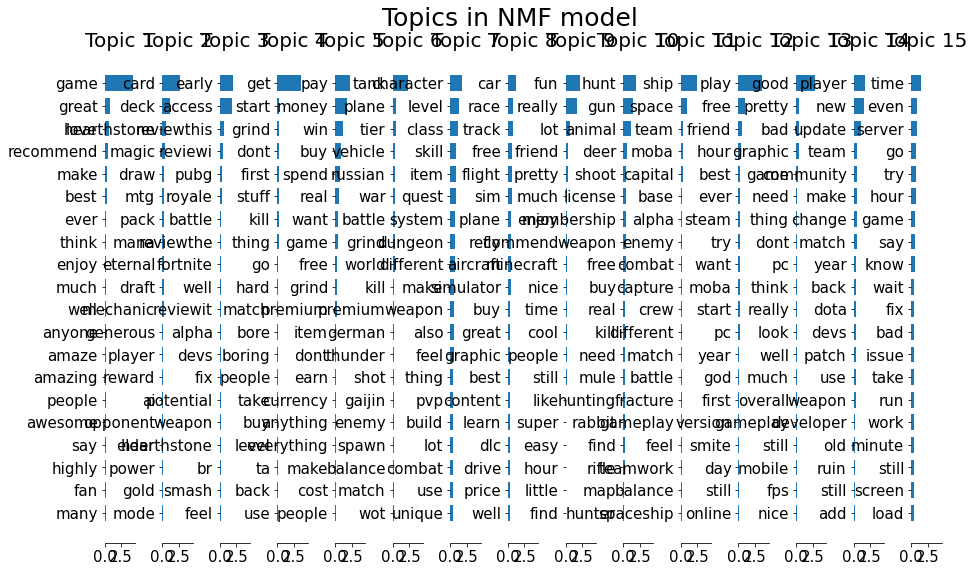

In [32]:
n_top_words = 20
tfidf_feature_names = vectorizer.get_feature_names()
W = topic_model9.components_

plot_top_words(W, tfidf_feature_names, n_top_words, "Topics in NMF model", 15)


In [26]:
def plot_tsne(H, topic_name_dict, title='Visualization of Game Review'):
    tsne = TSNE(random_state=42, learning_rate=100)
    tsne_trans = tsne.fit_transform(H)
    tsne_trans = pd.DataFrame(tsne_trans, columns = ['TSNE1', 'TSNE2'])

    tsne_trans['class'] = np.argmax(H, axis = 1)
    tsne_trans['class'] = tsne_trans['class'].replace(topic_name_dict)

    plt.figure(figsize=(15,15))
    sns.scatterplot(x = 'TSNE1', y = 'TSNE2', hue = 'class', data = tsne_trans, palette = 'tab10')
    plt.title(title)
    plt.show()

c:\Users\yanha\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


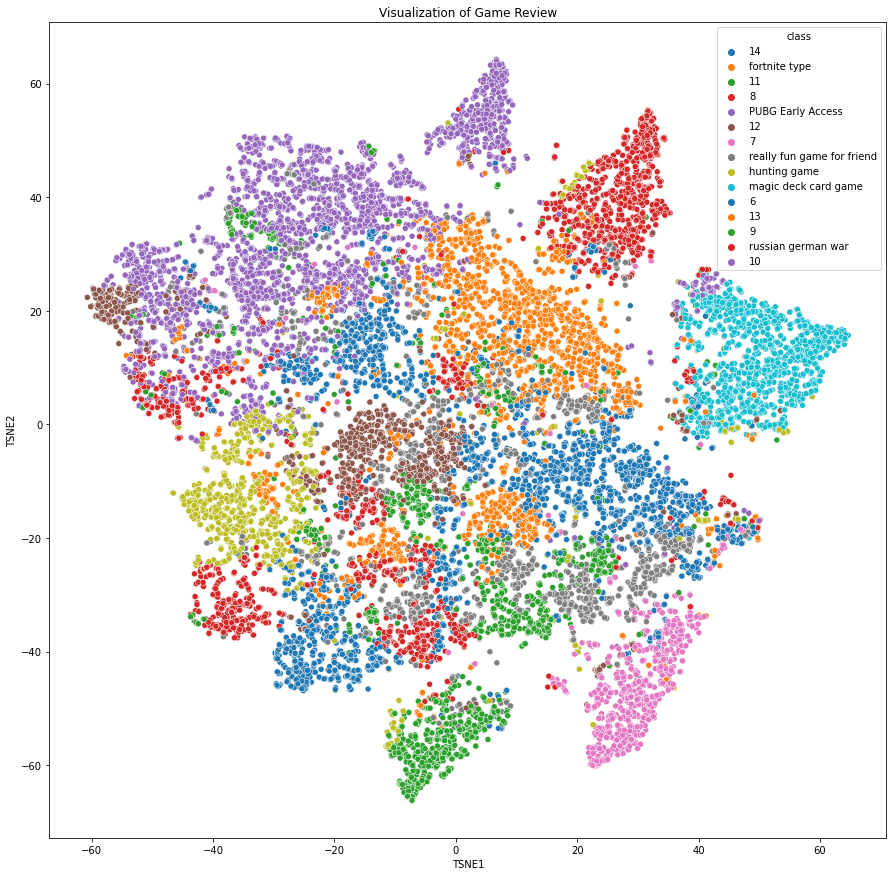

In [35]:
H = topic_model9.transform(X_train)
topic_name_dict_9 = {0: 'really fun game for friend', 1: 'magic deck card game', 2: 'PUBG Early Access',
                   3: 'fortnite type', 4: 'hunting game', 5:'russian german war',6:'6', 7:'7', 8:'8', 9:'9',
                    10:'10', 11:'11', 12:'12', 13:'13', 14:'14'}

plot_tsne(H, topic_name_dict_9)